In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [5]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix, fn_plot_tf_hist

In [6]:
import tensorflow as tf

2024-05-23 18:04:40.270796: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 18:04:40.319391: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 18:04:40.319431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 18:04:40.320707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 18:04:40.328166: I tensorflow/core/platform/cpu_feature_guar

In [7]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()




In [8]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [28]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [9]:
modelDir=r"/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day8/models"
subDir=r"fifa_2019"
logDir=r"/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day8/logs"


RANDOM_STATE = 24 
EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
REG_LAMBDA=0.001

PATIENCE=20
LR_PATIENCE=10
LR_FACTOR=0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [10]:
data_df = pd.read_csv(r'/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day8/input/fifa_2019.csv')
data_df.shape

(18207, 89)

In [11]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [12]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [13]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [14]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer") # if we dont downcast, it will be float 64

In [15]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [16]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}
class_labels
list(class_labels.keys())

[0, 1, 2, 3]

In [17]:
features_df = data_df.drop('Position',axis=1)
label = data_df['Position']

In [18]:

X_train,X_test,y_train,y_test  = train_test_split(features_df, label,
                                                  stratify=label,
                                                  test_size=TEST_SIZE, 
                                                  random_state=RANDOM_STATE )



In [19]:
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [20]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [21]:
X_train.shape

(14517, 33)

In [22]:
k_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
# k_reg=tf.keras.regularizers.L2(l2=REG_LAMBDA)
k_reg=None

# ### Dropout rate-1
# dor1=0.1
# dor2=0.2
# dor3=0.3
# dor4=0.4

### Dropout rate-2
# dor1=0.25
# dor2=0.25
# dor3=0.25
# dor4=0.25

### Dropout rate-3
dor1=0.4
dor2=0.3
dor3=0.2
dor4=0.1

### Dropout rate-4
# dor1=0.15
# dor2=0.25
# dor3=0.35
# dor4=0.45

### Dropout rate-5
# dor1=0.5
# dor2=0.15
# dor3=0.25
# dor4=0.35

### Dropout rate- RANDOM and RIDICULOUS
# dor1=2
# dor2=1
# dor3=0.001
# dor4=0


model=tf.keras.Sequential((
    
    # Input
    tf.keras.layers.InputLayer(input_shape=(33,)),
    
    # Set 1
    tf.keras.layers.Dense(33, 
                        #activation='relu', 
                          kernel_initializer=k_init, kernel_regularizer=k_reg),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(33),
    #tf.keras.layers.Dropout(dor1),
    
    
    
    # Set 2
    tf.keras.layers.Dense(23, 
                        #activation='relu', 
                        kernel_initializer=k_init, kernel_regularizer=k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(33),
    
    #tf.keras.layers.Dropout(dor2),

    # Set 3
    tf.keras.layers.Dense(12, 
                        # activation='relu', 
                        kernel_initializer=k_init, kernel_regularizer=k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(33),
    
    #tf.keras.layers.Dropout(dor3),

    # Set 4
    tf.keras.layers.Dense(4,
                    # activation='relu',
                    kernel_initializer=k_init, kernel_regularizer=k_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(33),
    
    #tf.keras.layers.Dropout(dor4),

    # Output Layer
    tf.keras.layers.Dense(4)
    
    
))

2024-05-23 18:04:43.967009: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### CALLBACKS

In [23]:
chechpoint_path=os.path.join(modelDir, subDir, 'weight_tf_fifa')


model_checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(
    chechpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
#   save_freq='epoch',
#   initial_value_threshold=None
)


es_callback= tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta=0,
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    # baseline=None,
    restore_best_weights=True
    # start_from_epoch=0
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    #min_delta=0.0001,
    #cooldown=0,
    min_lr=0.00001,
    # **kwargs
)

log_dir = os.path.join(logDir, 'fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Epoch 42: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.     (min_lr=0.00001)
# 454/454 - 3s - loss: 0.2784 - accuracy: 0.8843 - val_loss: 0.2966 - val_accuracy: 0.8730 - lr: 1.0000e-04 - 3s/epoch - 6ms/step
# Epoch 42: early stoppings

In [24]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.20008738,  0.0711351 , -0.16844675,  0.03779022]],
      dtype=float32)>

In [25]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)



In [26]:
model.compile(optimizer=optimizer, loss=loss_fn,metrics=['accuracy'])

history=model.fit(X_train, y_train, validation_data=[X_test, y_test],
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  callbacks=[model_checkpoint_callback, es_callback,lr_callback,tensorboard_callback],
                  verbose=2)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.55925, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day8/models/fifa_2019/weight_tf_fifa
454/454 - 6s - loss: 0.7979 - accuracy: 0.7341 - val_loss: 0.5592 - val_accuracy: 0.8030 - lr: 0.0010 - 6s/epoch - 13ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.55925 to 0.41638, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day8/models/fifa_2019/weight_tf_fifa
454/454 - 3s - loss: 0.5160 - accuracy: 0.8332 - val_loss: 0.4164 - val_accuracy: 0.8631 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.41638 to 0.33799, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day8/models/fifa_2019/weight_tf_fifa
454/454 - 3s - loss: 0.3990 - accuracy: 0.8495 - val_loss: 0.3380 - val_accuracy: 0.8645 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.33799 to 0.31939, saving model to /

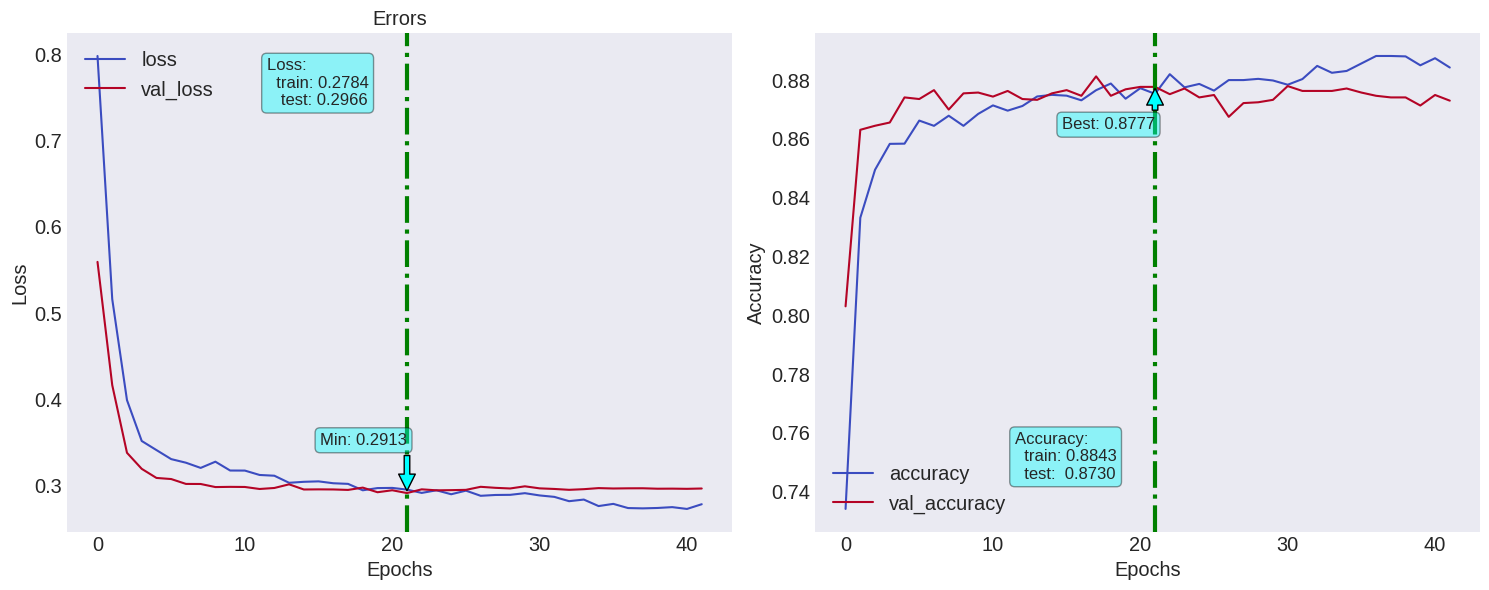

In [29]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [30]:
y_pred = model(X_train).numpy()
y_pred

array([[-8.223865 , -5.6565084,  1.2298706,  3.9144008],
       [-7.0821633, -3.8107657,  2.346427 ,  1.8179888],
       [-8.478913 , -3.854373 ,  2.6806848,  1.4984604],
       ...,
       [ 5.7081456, -3.6699266, -4.8218107, -7.391145 ],
       [ 6.7872972, -2.5169377, -4.966595 , -8.224014 ],
       [ 4.5441766, -5.133891 , -4.773753 , -6.5405145]], dtype=float32)

In [31]:
print(classification_report( y_train, y_pred.argmax( axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.93      0.93      4693
           2       0.84      0.89      0.86      5470
           3       0.89      0.76      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [32]:
y_pred = model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.87769


In [33]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.93      0.92      1173
           2       0.82      0.88      0.85      1368
           3       0.86      0.72      0.78       684

    accuracy                           0.88      3630
   macro avg       0.90      0.88      0.89      3630
weighted avg       0.88      0.88      0.88      3630



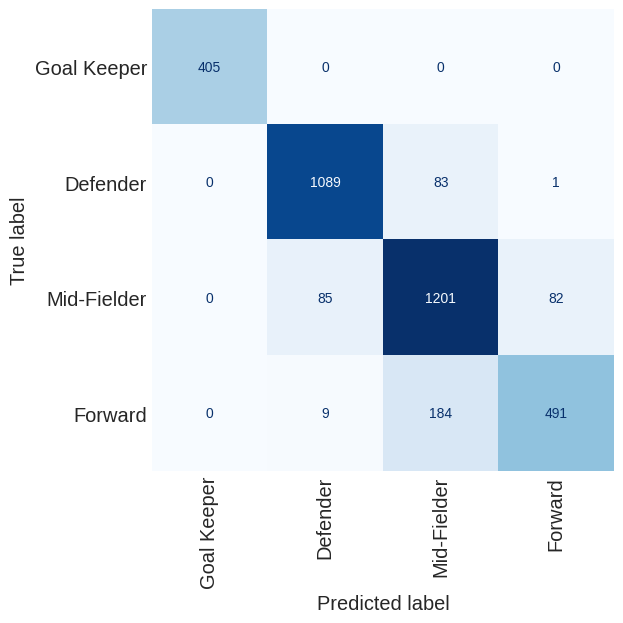

In [34]:
fn_plot_confusion_matrix( y_test, y_pred.argmax( axis = 1), labels=class_labels)

In [35]:
model.evaluate(X_test, y_test)

114/114 [==============================] - 0s 3ms/step - loss: 0.2913 - accuracy: 0.8777


[0.29131823778152466, 0.8776859641075134]

### tensorboard --logdir=fit